This is the backup for using regular neg MSE as the objective

import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet

from sklearn.metrics import mean_squared_error, r2_score

First, read the pre-split data

In [2]:
# Load the pre-split data
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv').squeeze()  # Convert to Series
y_test = pd.read_csv('data/y_test.csv').squeeze()    # Convert to Series

In [3]:
print(X_train.shape)

(329, 28)


In [4]:
# Check data types
print(X_train.dtypes)


resistance_line                     float64
support_line                        float64
start_date                           object
end_date                             object
num_candles                         float64
price_range_pct                     float64
num_res_hits                        float64
num_sup_hits                        float64
num_res_breakouts                   float64
num_sup_breakouts                   float64
alternation                         float64
last_candle_return                  float64
last_candle_pct_above_support       float64
resistance_hits                      object
support_hits                         object
breakout_type                        object
concentration_score                 float64
customer_pre_sideway_bar_change     float64
customer_post_sideway_bar_change    float64
pre_sideway_5_bar_change            float64
pre_sideway_10_bar_change           float64
pre_sideway_22_bar_change           float64
pre_sideway_44_bar_change       

In [5]:
print(y_train.dtypes)

float64


In [6]:
# Check for missing values
print(X_train.isnull().sum())
print(y_train.isnull().sum())

resistance_line                     0
support_line                        0
start_date                          0
end_date                            0
num_candles                         0
price_range_pct                     0
num_res_hits                        0
num_sup_hits                        0
num_res_breakouts                   0
num_sup_breakouts                   0
alternation                         0
last_candle_return                  0
last_candle_pct_above_support       0
resistance_hits                     0
support_hits                        0
breakout_type                       0
concentration_score                 0
customer_pre_sideway_bar_change     0
customer_post_sideway_bar_change    2
pre_sideway_5_bar_change            0
pre_sideway_10_bar_change           0
pre_sideway_22_bar_change           0
pre_sideway_44_bar_change           0
pre_sideway_132_bar_change          0
post_sideway_5_bar_change           0
concentration_score_scaled          0
alternation_

Initialization of feature sets and models / hyperparameter grids

In [ ]:
# Define the feature sets to experiment with
feature_sets = {
    'Feature_Set_1': ['num_candles','price_range_pct', 'num_res_hits', 'num_sup_hits', 'num_res_breakouts',
       'num_sup_breakouts', 'alternation', 'last_candle_return',
       'last_candle_pct_above_support',
       'concentration_score_scaled', 'alternation_score_scaled'],
    'Feature_Set_2': ['num_candles','price_range_pct', 'num_res_hits', 'num_sup_hits', 'num_res_breakouts',
       'num_sup_breakouts', 'alternation', 'last_candle_return',
       'last_candle_pct_above_support'],
    'Feature_Set_3': ['num_candles','price_range_pct', 'num_res_hits', 'num_sup_hits', 'num_res_breakouts',
       'num_sup_breakouts', 'alternation', 'last_candle_return'],
    'Feature_Set_4': ['num_candles','price_range_pct', 'num_res_hits', 'num_sup_hits', 'num_res_breakouts',
       'num_sup_breakouts', 'alternation', 'last_candle_return',
       'last_candle_pct_above_support',
       'concentration_score_scaled', 'alternation_score_scaled',
       'pre_sideway_5_bar_change', 'pre_sideway_10_bar_change'],
    'Feature_Set_5': ['num_candles','price_range_pct', 'num_res_hits', 'num_sup_hits', 'num_res_breakouts',
       'num_sup_breakouts', 'alternation', 'last_candle_return',
       'last_candle_pct_above_support',
       'concentration_score_scaled', 'alternation_score_scaled',
       'pre_sideway_5_bar_change', 'pre_sideway_10_bar_change',
       'pre_sideway_22_bar_change', 'pre_sideway_44_bar_change',
       'pre_sideway_132_bar_change'
       ]
    # Add more feature sets as needed
}
# feature set 1 is everything
# feature set 2 is based on feature importance and domain
# feature set 3 is reduction of feature set 2
# feature set 4 is feature set 1 + presideways bar change (5,10) since no missing values
# feature set 5 is feature set 1 + all presideway bar changes (5,10,22,44,132) where imputation of missing values handled with 0

# Define models and hyperparameter grids
models_and_params = {
    'Linear Regression': {
        'model': LinearRegression(),
        'param_grid': {}  # No hyperparameters to tune for Linear Regression
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [5, 10],
            'min_samples_split': [2, 5]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(objective='reg:squarederror', random_state=42),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.1, 0.2],
            'subsample': [0.8, 1.0]
        }
    },
    'Lasso Regression': {
        'model': Lasso(random_state=42),
        'param_grid': {
            'alpha': [0.01, 0.1, 1.0, 10.0]
        }
    },
    'Ridge Regression': {
        'model': Ridge(random_state=42),
        'param_grid': {
            'alpha': [0.01, 0.1, 1.0, 10.0]
        }
    },
    'Elastic Net Regression': {
        'model': ElasticNet(random_state=42),
        'param_grid': {
            'alpha': [0.01, 0.1, 1.0, 10.0],
            'l1_ratio': [0.2, 0.5, 0.8]  # Controls L1 vs. L2 contribution
        }
    }
}

Search for best-performing model for each feature-set and overall

In [131]:
from tqdm import tqdm

# Initialize a results DataFrame
results = []

# Wrap the outer loop (feature sets) with tqdm
for feature_set_name, feature_set in tqdm(feature_sets.items(), desc="Feature Sets"):
    print(f"\nProcessing Feature Set: {feature_set_name} with features: {feature_set}")
    
    # Select the relevant features for the current feature set
    X_train_subset = X_train[feature_set]
    X_test_subset = X_test[feature_set]
    
    # Wrap the inner loop (models) with tqdm
    for model_name, model_info in tqdm(models_and_params.items(), desc=f"Models for {feature_set_name}", leave=False):
        print(f"  Training Model: {model_name}")
        model = model_info['model']
        param_grid = model_info['param_grid']
        
        # Perform hyperparameter tuning (if applicable)
        if param_grid:
            print(f"    Performing Grid Search for {model_name}...")
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                                       scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
            grid_search.fit(X_train_subset, y_train)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            print(f"    Best Params for {model_name}: {best_params}")
        else:
            # For models with no hyperparameter tuning (e.g., Linear Regression)
            model.fit(X_train_subset, y_train)
            best_model = model
            best_params = {}
        
        # Make predictions and evaluate
        y_pred = best_model.predict(X_test_subset)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"    {model_name} - MSE: {mse:.4f}, R^2: {r2:.4f}")
        
        # Store results
        results.append({
            'Feature_Set': feature_set_name,
            'Model': model_name,
            'Best_Params': best_params,
            'MSE': mse,
            'R^2': r2
        })

Feature Sets:   0%|          | 0/5 [00:00<?, ?it/s]


Processing Feature Set: Feature_Set_1 with features: ['num_candles', 'price_range_pct', 'num_res_hits', 'num_sup_hits', 'num_res_breakouts', 'num_sup_breakouts', 'alternation', 'last_candle_return', 'last_candle_pct_above_support', 'concentration_score_scaled', 'alternation_score_scaled']


  Training Model: Linear Regression
    Linear Regression - MSE: 0.0008, R^2: 0.4168
  Training Model: Random Forest
    Performing Grid Search for Random Forest...


    Best Params for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
    Random Forest - MSE: 0.0006, R^2: 0.5274
  Training Model: XGBoost
    Performing Grid Search for XGBoost...


Feature Sets:  20%|██        | 1/5 [00:14<00:58, 14.51s/it]

    Best Params for XGBoost: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
    XGBoost - MSE: 0.0007, R^2: 0.4511
  Training Model: Lasso Regression
    Performing Grid Search for Lasso Regression...
    Best Params for Lasso Regression: {'alpha': 0.01}
    Lasso Regression - MSE: 0.0010, R^2: 0.2834
  Training Model: Ridge Regression
    Performing Grid Search for Ridge Regression...
    Best Params for Ridge Regression: {'alpha': 10.0}
    Ridge Regression - MSE: 0.0008, R^2: 0.4226
  Training Model: Elastic Net Regression
    Performing Grid Search for Elastic Net Regression...
    Best Params for Elastic Net Regression: {'alpha': 0.01, 'l1_ratio': 0.2}
    Elastic Net Regression - MSE: 0.0007, R^2: 0.4399

Processing Feature Set: Feature_Set_2 with features: ['num_candles', 'price_range_pct', 'num_res_hits', 'num_sup_hits', 'num_res_breakouts', 'num_sup_breakouts', 'alternation', 'last_candle_return', 'last_candle_pct_above_support']


  Training Model: Linear Regression
    Linear Regression - MSE: 0.0008, R^2: 0.4151
  Training Model: Random Forest
    Performing Grid Search for Random Forest...


    Best Params for Random Forest: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
    Random Forest - MSE: 0.0006, R^2: 0.5663
  Training Model: XGBoost
    Performing Grid Search for XGBoost...


Feature Sets:  40%|████      | 2/5 [00:18<00:25,  8.48s/it]

    Best Params for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
    XGBoost - MSE: 0.0008, R^2: 0.4214
  Training Model: Lasso Regression
    Performing Grid Search for Lasso Regression...
    Best Params for Lasso Regression: {'alpha': 0.01}
    Lasso Regression - MSE: 0.0010, R^2: 0.2834
  Training Model: Ridge Regression
    Performing Grid Search for Ridge Regression...
    Best Params for Ridge Regression: {'alpha': 10.0}
    Ridge Regression - MSE: 0.0008, R^2: 0.4225
  Training Model: Elastic Net Regression
    Performing Grid Search for Elastic Net Regression...
    Best Params for Elastic Net Regression: {'alpha': 0.01, 'l1_ratio': 0.2}
    Elastic Net Regression - MSE: 0.0007, R^2: 0.4399

Processing Feature Set: Feature_Set_3 with features: ['num_candles', 'price_range_pct', 'num_res_hits', 'num_sup_hits', 'num_res_breakouts', 'num_sup_breakouts', 'alternation', 'last_candle_return']


  Training Model: Linear Regression
    Linear Regression - MSE: 0.0011, R^2: 0.1697
  Training Model: Random Forest
    Performing Grid Search for Random Forest...


    Best Params for Random Forest: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
    Random Forest - MSE: 0.0010, R^2: 0.2396
  Training Model: XGBoost
    Performing Grid Search for XGBoost...


Feature Sets:  60%|██████    | 3/5 [00:22<00:13,  6.53s/it]

    Best Params for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
    XGBoost - MSE: 0.0010, R^2: 0.2434
  Training Model: Lasso Regression
    Performing Grid Search for Lasso Regression...
    Best Params for Lasso Regression: {'alpha': 0.01}
    Lasso Regression - MSE: 0.0014, R^2: -0.0585
  Training Model: Ridge Regression
    Performing Grid Search for Ridge Regression...
    Best Params for Ridge Regression: {'alpha': 0.01}
    Ridge Regression - MSE: 0.0011, R^2: 0.1664
  Training Model: Elastic Net Regression
    Performing Grid Search for Elastic Net Regression...
    Best Params for Elastic Net Regression: {'alpha': 0.01, 'l1_ratio': 0.2}
    Elastic Net Regression - MSE: 0.0014, R^2: -0.0252

Processing Feature Set: Feature_Set_4 with features: ['num_candles', 'price_range_pct', 'num_res_hits', 'num_sup_hits', 'num_res_breakouts', 'num_sup_breakouts', 'alternation', 'last_candle_return', 'last_candle_pct_above_support', 'concentration

  Training Model: Linear Regression
    Linear Regression - MSE: 0.0008, R^2: 0.3886
  Training Model: Random Forest
    Performing Grid Search for Random Forest...


    Best Params for Random Forest: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
    Random Forest - MSE: 0.0006, R^2: 0.5818
  Training Model: XGBoost
    Performing Grid Search for XGBoost...


Feature Sets:  80%|████████  | 4/5 [00:29<00:06,  6.57s/it]

    Best Params for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
    XGBoost - MSE: 0.0008, R^2: 0.4016
  Training Model: Lasso Regression
    Performing Grid Search for Lasso Regression...
    Best Params for Lasso Regression: {'alpha': 0.01}
    Lasso Regression - MSE: 0.0010, R^2: 0.2834
  Training Model: Ridge Regression
    Performing Grid Search for Ridge Regression...
    Best Params for Ridge Regression: {'alpha': 10.0}
    Ridge Regression - MSE: 0.0008, R^2: 0.4237
  Training Model: Elastic Net Regression
    Performing Grid Search for Elastic Net Regression...
    Best Params for Elastic Net Regression: {'alpha': 0.01, 'l1_ratio': 0.2}
    Elastic Net Regression - MSE: 0.0007, R^2: 0.4399

Processing Feature Set: Feature_Set_5 with features: ['num_candles', 'price_range_pct', 'num_res_hits', 'num_sup_hits', 'num_res_breakouts', 'num_sup_breakouts', 'alternation', 'last_candle_return', 'last_candle_pct_above_support', 'concentration_s

  Training Model: Linear Regression
    Linear Regression - MSE: 0.0008, R^2: 0.3984
  Training Model: Random Forest
    Performing Grid Search for Random Forest...


    Best Params for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
    Random Forest - MSE: 0.0006, R^2: 0.5286
  Training Model: XGBoost
    Performing Grid Search for XGBoost...


Feature Sets: 100%|██████████| 5/5 [00:37<00:00,  7.43s/it]

    Best Params for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
    XGBoost - MSE: 0.0008, R^2: 0.4217
  Training Model: Lasso Regression
    Performing Grid Search for Lasso Regression...
    Best Params for Lasso Regression: {'alpha': 0.01}
    Lasso Regression - MSE: 0.0010, R^2: 0.2834
  Training Model: Ridge Regression
    Performing Grid Search for Ridge Regression...
    Best Params for Ridge Regression: {'alpha': 10.0}
    Ridge Regression - MSE: 0.0007, R^2: 0.4379
  Training Model: Elastic Net Regression
    Performing Grid Search for Elastic Net Regression...
    Best Params for Elastic Net Regression: {'alpha': 0.01, 'l1_ratio': 0.2}
    Elastic Net Regression - MSE: 0.0007, R^2: 0.4399


In [132]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results)
results_df.head()

,Feature_Set,Model,Best_Params,MSE,R^2
0,Feature_Set_1,Linear Regression,{},0.000776,0.416764
1,Feature_Set_1,Random Forest,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",0.000629,0.527394
2,Feature_Set_1,XGBoost,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti...",0.000730,0.451103
3,Feature_Set_1,Lasso Regression,{'alpha': 0.01},0.000953,0.283446
4,Feature_Set_1,Ridge Regression,{'alpha': 10.0},0.000768,0.422606


In [133]:
# Display the best model for each feature set based on R^2
best_per_feature_set = results_df.loc[results_df.groupby('Feature_Set')['R^2'].idxmax()]
print("\nBest Model for Each Feature Set:")
print(best_per_feature_set[['Feature_Set', 'Model', 'R^2', 'MSE']])

# Display the overall best model across all feature sets
overall_best = results_df.loc[results_df['R^2'].idxmax()]
print("\nOverall Best Model:")
print(overall_best[['Model','Feature_Set','Best_Params']].values)


Best Model for Each Feature Set:
      Feature_Set          Model       R^2       MSE
1   Feature_Set_1  Random Forest  0.527394  0.000629
7   Feature_Set_2  Random Forest  0.566299  0.000577
14  Feature_Set_3        XGBoost  0.243368  0.001006
19  Feature_Set_4  Random Forest  0.581758  0.000556
25  Feature_Set_5  Random Forest  0.528560  0.000627

Overall Best Model:
['Random Forest' 'Feature_Set_4'
 {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}]


In [134]:
best_feature_set

['num_candles',
 'price_range_pct',
 'num_res_hits',
 'num_sup_hits',
 'num_res_breakouts',
 'num_sup_breakouts',
 'alternation',
 'last_candle_return',
 'last_candle_pct_above_support',
 'concentration_score_scaled',
 'alternation_score_scaled',
 'pre_sideway_5_bar_change',
 'pre_sideway_10_bar_change']

In [135]:
# Extract the best model details
best_model_name = overall_best['Model']
best_feature_set_name = overall_best['Feature_Set']
best_params = overall_best['Best_Params']
best_feature_set = feature_sets[best_feature_set_name]

#best_feature_set = feature_sets['Feature_Set_5']

print(f"Features in Best Feature Set: {best_feature_set}")

from sklearn.ensemble import RandomForestRegressor

# Subset the training data using the best feature set
X_train_best = X_train[best_feature_set]

# Re-train the best Random Forest model with the saved parameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train_best, y_train)

print("Best Random Forest Model Retrained!")


Features in Best Feature Set: ['num_candles', 'price_range_pct', 'num_res_hits', 'num_sup_hits', 'num_res_breakouts', 'num_sup_breakouts', 'alternation', 'last_candle_return', 'last_candle_pct_above_support', 'concentration_score_scaled', 'alternation_score_scaled', 'pre_sideway_5_bar_change', 'pre_sideway_10_bar_change']
Best Random Forest Model Retrained!


# Only can plot feature importance if its RF

Feature Importances for Best Random Forest Model:
                          Feature  Importance
8   last_candle_pct_above_support    0.590924
1                 price_range_pct    0.223354
9      concentration_score_scaled    0.057047
11       pre_sideway_5_bar_change    0.029375
12      pre_sideway_10_bar_change    0.025106
0                     num_candles    0.023974
7              last_candle_return    0.017454
3                    num_sup_hits    0.014513
2                    num_res_hits    0.006258
4               num_res_breakouts    0.006069
5               num_sup_breakouts    0.003643
10       alternation_score_scaled    0.001163
6                     alternation    0.001120


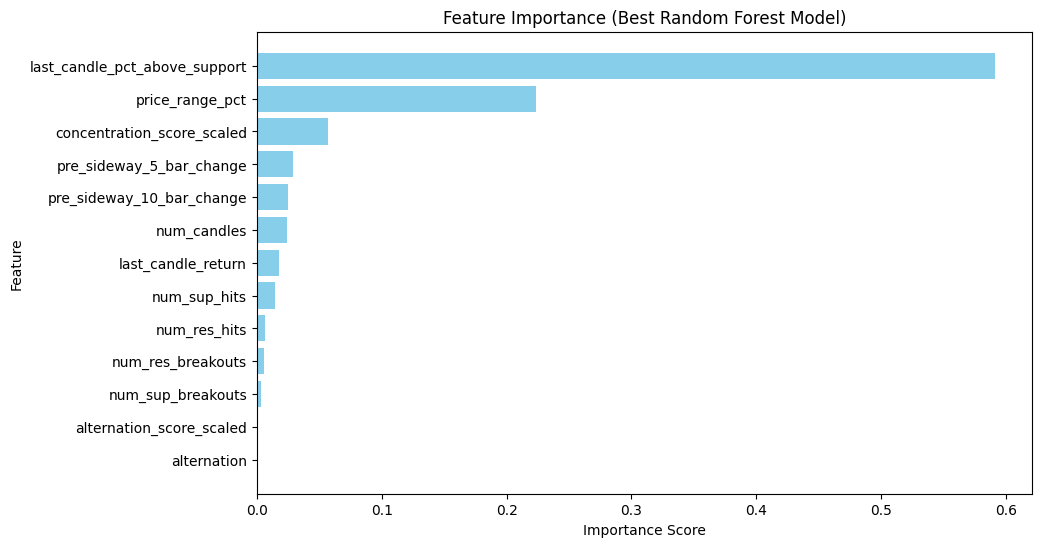

In [136]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance values
feature_importances = best_rf_model.feature_importances_

# Match them with feature names
importance_df = pd.DataFrame({
    'Feature': best_feature_set,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the importance DataFrame
print("Feature Importances for Best Random Forest Model:")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title('Feature Importance (Best Random Forest Model)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

#1 run: Original X and Original y

Best Model for Each Feature Set:
     Feature_Set          Model       R^2       MSE
1  Feature_Set_1  Random Forest  0.159093  0.001310
4  Feature_Set_2  Random Forest  0.161914  0.001305
7  Feature_Set_3  Random Forest  0.168403  0.001295

Overall Best Model:
Feature_Set    Feature_Set_3
Model          Random Forest
R^2                 0.168403
MSE                 0.001295
Name: 7, dtype: object


#2 run: Modified X and Original y
Modified refers to excluding those "violating" sideways
Best Model for Each Feature Set:
     Feature_Set          Model       R^2       MSE
1  Feature_Set_1  Random Forest  0.491088  0.000601
4  Feature_Set_2  Random Forest  0.472735  0.000622
7  Feature_Set_3  Random Forest  0.310111  0.000814

Overall Best Model:
Feature_Set    Feature_Set_1
Model          Random Forest
R^2                 0.491088
MSE                 0.000601
Name: 1, dtype: object

#3 run: Modified X (+ exclusion of sideways longer than 220 candles) and Original y
Best Model for Each Feature Set:
     Feature_Set          Model       R^2       MSE
1  Feature_Set_1  Random Forest  0.527394  0.000629
4  Feature_Set_2  Random Forest  0.566299  0.000577
8  Feature_Set_3        XGBoost  0.243368  0.001006

Overall Best Model:
Feature_Set    Feature_Set_2
Model          Random Forest
R^2                 0.566299
MSE                 0.000577

while Feature set 2 demonstrate the best, but i think we should choose Feature set 1 -> see the feature importance ... it also uses concentration score. so next step is to improve the alternation computation because obviously here it does really use for determining the breakthrough percent change

Feature Importances for Best Random Forest Model:
                          Feature  Importance
8   last_candle_pct_above_support    0.596197
1                 price_range_pct    0.237161
9      concentration_score_scaled    0.061028
0                     num_candles    0.037345
7              last_candle_return    0.027842
3                    num_sup_hits    0.012969
4               num_res_breakouts    0.008286
2                    num_res_hits    0.008237
5               num_sup_breakouts    0.006758
6                     alternation    0.002091
10       alternation_score_scaled    0.002086



#4 run: same as #3 but 
Best Model for Each Feature Set:
      Feature_Set          Model       R^2       MSE
1   Feature_Set_1  Random Forest  0.527394  0.000629
4   Feature_Set_2  Random Forest  0.566299  0.000577
8   Feature_Set_3        XGBoost  0.243368  0.001006
10  Feature_Set_4  Random Forest  0.581758  0.000556

Overall Best Model:
['Random Forest' 'Feature_Set_4'
 {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}]